In [2]:
from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/qbo_data.csv",index_col="run_id")
df = df.sort_values("qbo_period_std")
df

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


,cw,Bt,qbo_periods,qbo_period_std,qbo_period_fft,qbo_count,qbo_rmse_ampltiude,qbo_amplitude_mean,qbo_amplitude_std
run_id,,,,,,,,,
78,63.111004,0.002280,11.466667,3.984022e-15,11.466667,19,12.475006,17.731903,0.000000
1,44.617037,0.005099,24.116463,8.522248e-01,24.000000,9,42.536683,39.017867,1.996191
64,49.812074,0.005277,23.683767,8.823445e-01,24.000000,9,46.075949,42.475577,1.897165
60,21.845038,0.006956,19.117979,1.263149e+00,18.461538,12,34.874135,35.291554,1.546429
15,33.698484,0.005147,24.227832,1.284637e+00,24.000000,9,40.913906,38.525333,2.027852
...,...,...,...,...,...,...,...,...,...
35,8.580488,0.005694,18.281435,1.201578e+01,26.666667,12,12.293360,11.247630,4.733746
52,17.041039,0.001164,28.288639,1.384765e+01,12.000000,8,10.699096,11.159743,3.234233
44,5.930840,0.004727,27.009087,1.428539e+01,12.000000,8,10.644768,11.106186,1.924817


## Constants

In [3]:
OBS_PERIOD_MEAN = 27.915249015787193
OBS_PERIOD_STD = 4.538404428603899

OBS_AMP_MEAN = 26.587500000000002
OBS_AMP_STD =2.953799762291663

CURRENT_CW = 35
CURRENT_BT = 0.0043

## todo
* combine all these operations into a single pipeline that transforms X,y directly -> predicts in natural space
* Move this architecture to proper py module file

In [4]:

import numpy as np
X = df[["Bt","cw"]].to_numpy()
y_point_error = df[["qbo_period_std","qbo_amplitude_std"]].to_numpy()
y = df[["qbo_periods","qbo_amplitude_mean"]].to_numpy()

mean_y = np.mean(y,axis=0)
std_y = np.std(y,axis=0)
y_norm = (y - mean_y)/std_y
y_point_error = y_point_error/std_y

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr_period = GaussianProcessRegressor(alpha=(y_point_error[:,0])**2)
gpr_amplitude = GaussianProcessRegressor(alpha=(y_point_error[:,1])**2)
gpr_period.fit(X_scaled,y_norm[:,0])
gpr_amplitude.fit(X_scaled,y_norm[:,1])


GaussianProcessRegressor(alpha=array([0.        , 0.03549996, 0.03206519, 0.02130511, 0.03663503,
       0.10000635, 0.04755545, 0.02341443, 0.06873481, 0.02064695,
       0.04364164, 0.02059658, 0.03307179, 0.02997074, 0.02992444,
       0.03964912, 0.04184283, 0.03742722, 0.11043406, 0.05490023,
       0.03823451, 0.11996331, 0.01288341, 0.07016622, 0.01811312,
       0.02961625, 0.03895552, 0.03613724, 0.02275002, 0...
       0.06821497, 0.04865237, 0.03485085, 0.06325704, 0.40887736,
       0.18426707, 0.07807244, 0.05403737, 0.50658962, 0.11072214,
       0.25057328, 0.00183975, 0.24559099, 0.11531212, 0.0554244 ,
       0.58435664, 0.46871923, 0.11444193, 0.37895374, 0.05736947,
       0.45566798, 0.22893497, 0.07042133, 0.04721502, 0.12249928,
       0.07578465, 0.03409722, 0.0418027 , 0.04109161, 0.60180053,
       0.19963368, 0.09318942, 0.03300674, 0.06687922, 0.13468677]))

In [7]:
predval,predstd = gpr_period.predict(scaler.transform([[0.0043,35]]),return_std=True)
predval = predval*std_y[0] + mean_y[0]
predstd = predstd*std_y[0]

In [8]:
predval,predstd

(array([25.98154407]), array([0.70357845]))

### 3D Plots?

In [9]:
CW_POINTS = 1000
BT_POINTS = 1000
cw = np.linspace(5,70,CW_POINTS)
Bt = np.linspace(0.001,0.007,BT_POINTS)
X_Bt,Y_cw = np.meshgrid(Bt,cw)
x_samples = np.vstack((X_Bt.ravel(),Y_cw.ravel())).T
x_samples = scaler.transform(x_samples)


In [10]:
period,period_std = gpr_period.predict(x_samples,return_std=True)
period = period*std_y[0] + mean_y[0]
period = period.reshape((CW_POINTS,BT_POINTS))
period_std = (period_std*std_y[0]).reshape((CW_POINTS,BT_POINTS))


amplitude,amplitude_std = gpr_amplitude.predict(x_samples,return_std=True)
amplitude = amplitude*std_y[1] + mean_y[1]
amplitude = amplitude.reshape((CW_POINTS,BT_POINTS))
amplitude_std = (amplitude_std*std_y[1]).reshape((CW_POINTS,BT_POINTS))

In [11]:
implausability_period = np.abs(period - OBS_PERIOD_MEAN)/np.sqrt(OBS_PERIOD_STD**2 + period_std**2)
implausability_amplitude = np.abs(amplitude - OBS_AMP_MEAN)/np.sqrt(OBS_AMP_STD**2 + amplitude_std**2)
implausability = np.sqrt(implausability_amplitude**2 + implausability_period**2)

In [12]:
imp_cutoff = implausability < np.percentile(implausability,10)

ValueError: Invalid RGBA argument: 'lightred'

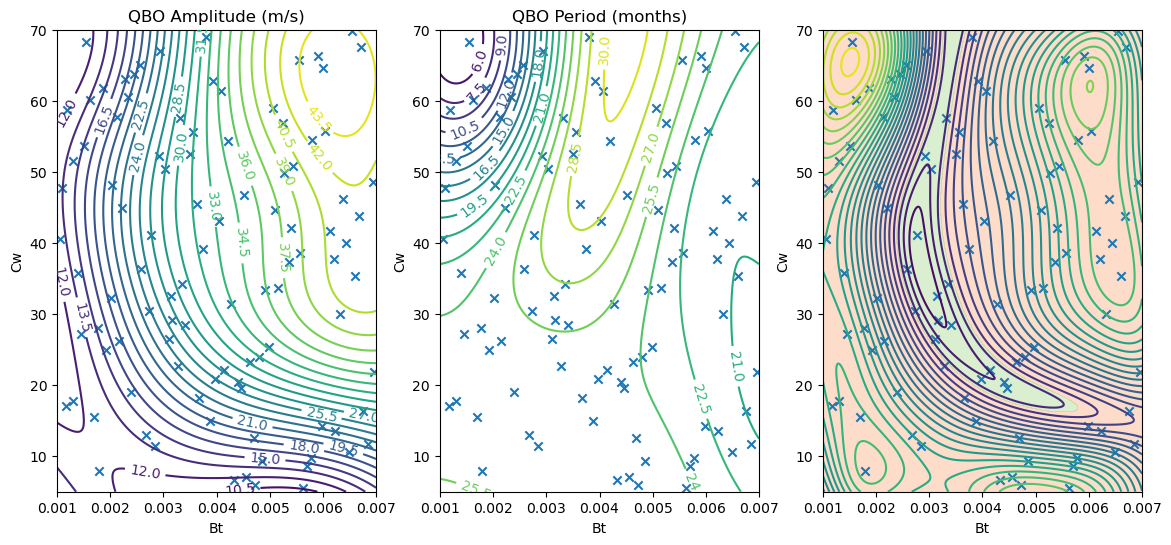

In [27]:
import matplotlib.patches as mpatches

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,6))
CS = ax1.contour(X_Bt,Y_cw,amplitude,levels=25)
ax1.scatter(X[:,0],X[:,1],marker='x')
ax1.clabel(CS, CS.levels, inline=True,  fontsize=10)
ax1.set_ylabel("Cw")
ax1.set_xlabel("Bt")
ax1.set_title("QBO Amplitude (m/s)")

CS2 = ax2.contour(X_Bt,Y_cw,period,levels=25)
ax2.scatter(X[:,0],X[:,1],marker='x')
ax2.clabel(CS2, CS2.levels, inline=True,  fontsize=10)
ax2.set_ylabel("Cw")
ax2.set_xlabel("Bt")
ax2.set_title("QBO Period (months)")

ax3.contour(X_Bt,Y_cw,implausability,levels=25)
CS3 = ax3.contourf(X_Bt,Y_cw,imp_cutoff,alpha=0.3,cmap='RdYlGn',levels=1)
ax3.scatter(X[:,0],X[:,1],marker='x')
ax3.set_ylabel("Cw")
ax3.set_xlabel("Bt")
ax3.legend(handles=[mpatches.Patch(color='lightgreen',label="Next iteration non-implusable space"),
                    mpatches.Patch(color='pink',label="Next iteration implausable space")])
ax3.set_title("Implausability")

Text(0.5, 0, 'Implausability')

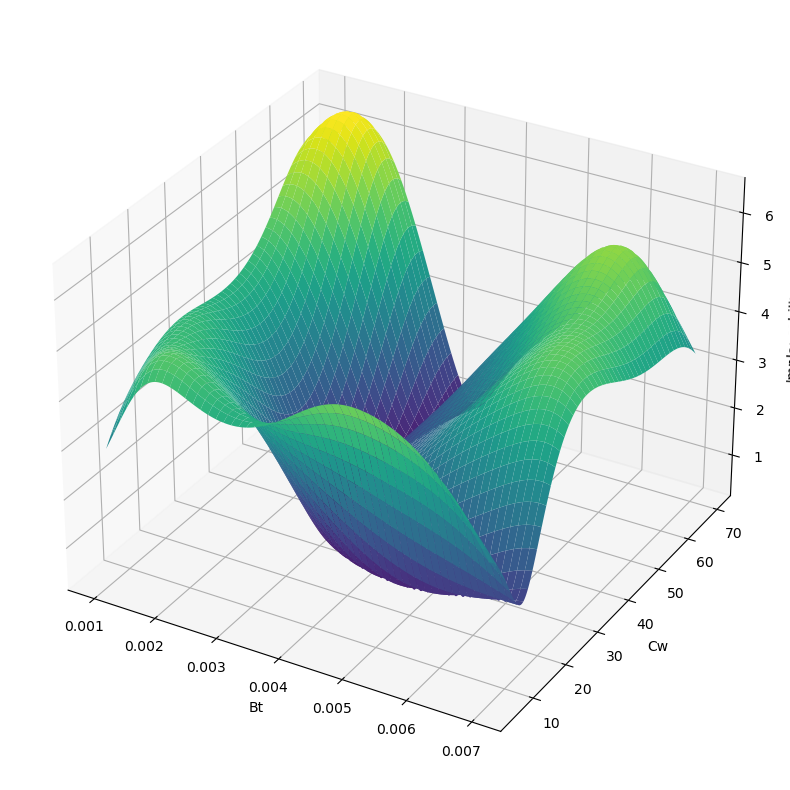

In [14]:
from mpl_toolkits.mplot3d import axes3d
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.plot_surface(X_Bt,Y_cw,implausability,cmap='viridis')
ax.set_xlabel("Bt")
ax.set_ylabel("Cw")
ax.set_zlabel("Implausability")

## Calculate Decision Boundary + Sampling

In [15]:
def get_new_samples(new_sample_space,X,Y,n_samples=100):
    """
    MCMC sampling.
    Probably not very
    Dimensions of new_sample_space,X,Y, must match
    """
    ## Calculating bounding box of new_sample_space.
    y_where,x_where = np.where(new_sample_space)
    x_min,x_max,y_min,y_max = X[0,np.min(x_where)],X[0,np.max(x_where)],Y[np.min(y_where),0],Y[np.max(y_where),0]
    new_samples = []
    while len(new_samples) < n_samples:
        # Sample random point in original sample space 
        x,y = np.random.uniform(low=(x_min,y_min),high=(x_max,y_max))
        col = np.argmin(np.abs(X-x),axis=1)[1]
        row = np.argmin(np.abs(Y-y),axis=0)[0]
        if new_sample_space[row,col]:
            new_samples.append((x,y))
        # Check sample point meets plausability criterion
    return np.array(new_samples)


In [16]:
new_samples = get_new_samples(imp_cutoff,X_Bt,Y_cw)
pd.DataFrame(new_samples,columns=("Bt","cw")).to_csv("../data/rounds/mcmc_round2_samples.csv")


### LHS

In [17]:
from pyDOE import lhs

def get_new_samples_lhs(new_sample_space,X,Y,n_samples=100,max_iter=1000):
    """
    MCMC sampling.
    Probably not very
    Dimensions of new_sample_space,X,Y, must match
    """
    ## Calculating bounding box of new_sample_space.
    y_where,x_where = np.where(new_sample_space)
    x_min,x_max,y_min,y_max = X[0,np.min(x_where)],X[0,np.max(x_where)],Y[np.min(y_where),0],Y[np.max(y_where),0]
    
    rescale = np.array([[x_max -x_min,0],[0,y_max-y_min],[x_min,y_min]])
    for i in range(1,max_iter):
        # Sample random point in original sample space 
        samples = lhs(2,samples=n_samples*i*5,criterion='m')
        samples = np.column_stack((samples,np.ones(n_samples*i*5))) @ rescale
        print(samples[:,1].min())
        rows,cols = (np.argmin(np.abs(Y[:,0,None] - samples[:,1][None,:]),axis=0),
                                  np.argmin(np.abs(X[0,:,None] - samples[:,0][None,:]),axis=0))
        valid = new_sample_space[cols,rows]
        if np.sum(valid) >= n_samples:
            ys,xs = Y[cols[valid],0],X[0,rows[valid]]
            return np.column_stack((xs,ys))
    raise RuntimeError(f"Unable to draw {n_samples} samples in {max_iter} iterations from the sample space")


In [18]:
lhs_samples = get_new_samples_lhs(imp_cutoff,X_Bt,Y_cw)

16.257214759528452
16.297426092488124


In [19]:
lhs_samples

array([[3.57057057e-03, 3.00500501e+01],
       [2.96396396e-03, 3.75975976e+01],
       [4.02702703e-03, 2.17217217e+01],
       [4.13513514e-03, 2.41291291e+01],
       [2.73573574e-03, 3.65565566e+01],
       [3.00600601e-03, 4.16966967e+01],
       [3.18618619e-03, 4.52102102e+01],
       [3.05405405e-03, 2.80980981e+01],
       [2.75975976e-03, 5.13913914e+01],
       [2.92792793e-03, 3.68818819e+01],
       [3.67267267e-03, 2.77077077e+01],
       [2.95195195e-03, 2.71871872e+01],
       [3.12612613e-03, 3.09609610e+01],
       [2.86786787e-03, 4.42992993e+01],
       [2.95795796e-03, 3.77927928e+01],
       [2.87987988e-03, 5.05455455e+01],
       [4.09309309e-03, 2.44544545e+01],
       [3.97297297e-03, 2.41941942e+01],
       [2.66966967e-03, 3.91591592e+01],
       [3.01801802e-03, 4.33883884e+01],
       [3.49849850e-03, 3.30430430e+01],
       [3.92492492e-03, 2.37387387e+01],
       [3.42642643e-03, 2.37387387e+01],
       [3.68468468e-03, 2.93343343e+01],
       [2.843843

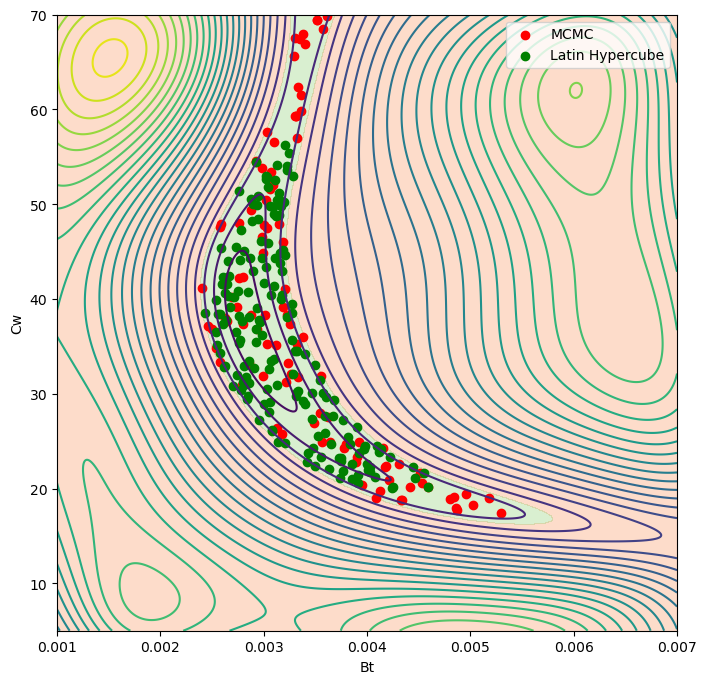

In [20]:
fig,(ax1) = plt.subplots(figsize=(8,8))


ax1.contour(X_Bt,Y_cw,implausability,levels=25)
ax1.contourf(X_Bt,Y_cw,imp_cutoff,alpha=0.3,cmap='RdYlGn',levels=1)
#ax1.scatter(CURRENT_BT,CURRENT_CW)
ax1.set_ylabel("Cw")
ax1.set_xlabel("Bt")
ax1.scatter(new_samples[:,0],new_samples[:,1],c='r',label="MCMC")
ax1.scatter(lhs_samples[:,0],lhs_samples[:,1],c='g',label="Latin Hypercube")
ax1.legend()